In [176]:
import os, cv2
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from keras import backend as K

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,  AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from PIL import Image

from tensorflow.python.client import device_lib
import pandas as pd

Number of breeds in dataset: 120


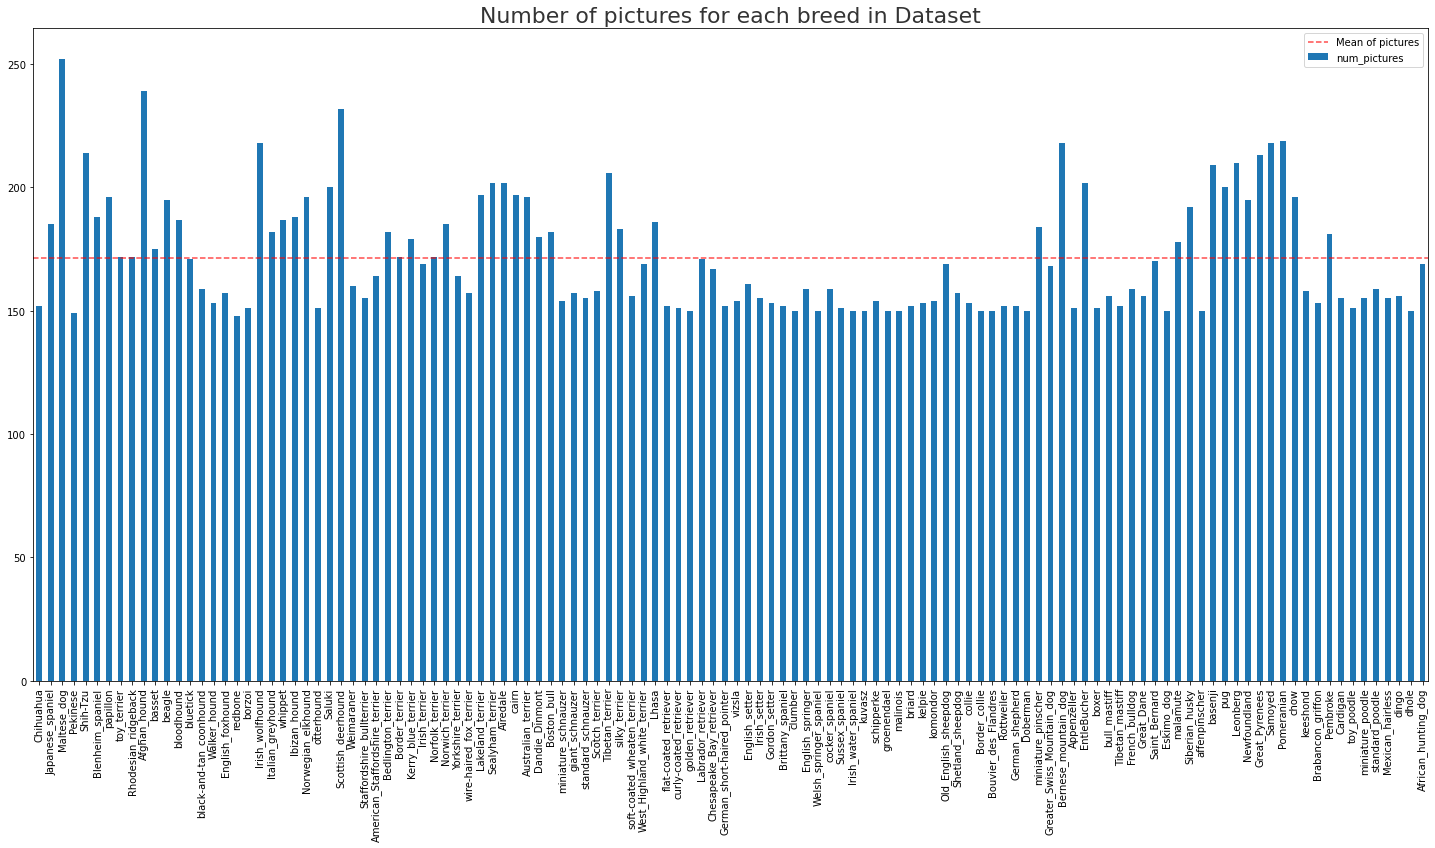

In [2]:
#From XceptRef

#Define paths
images_dir = "./input/stanford-dogs-dataset/images/Images/"
annotations_dir = '../input/stanford-dogs-dataset/annotations/Annotation'

# Count the number of classes (dogs breeds)
breed_list = os.listdir(images_dir)
print("Number of breeds in dataset:", (len(breed_list)))

#From XceptRef
# Count number of pictures for each breed
df_breeds = pd.DataFrame(
    index=[breed.split('-',1)[1] for breed in breed_list],
    data=[len(os.listdir(images_dir + "/" + name)) for name in breed_list],
    columns=["num_pictures"])

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(25,12))
df_breeds.plot(kind="bar",legend=False, ax=ax)
ax.axhline(df_breeds["num_pictures"].mean(), color='r', alpha=.7, linestyle='--', label="Mean of pictures")
plt.title("Number of pictures for each breed in Dataset", color="#343434", fontsize=22)
plt.legend()
plt.show()

In [3]:
categories = [
    'n02096294-Australian_terrier',
    'n02093256-Staffordshire_bullterrier',
    'n02099601-golden_retriever',
    'n02106662-German_shepherd',
    'n02086240-Shih-Tzu',
    'n02099712-Labrador_retriever',
    'n02088364-beagle',
    'n02100735-English_setter',
    'n02102318-cocker_spaniel',
    'n02108915-French_bulldog',
    'n02094433-Yorkshire_terrier',
    'n02085620-Chihuahua',
    'n02110185-Siberian_husky',
    'n02106166-Border_collie',
    'n02106550-Rottweiler']
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['n02096294-Australian_terrier', 'n02093256-Staffordshire_bullterrier', 'n02099601-golden_retriever', 'n02106662-German_shepherd', 'n02086240-Shih-Tzu', 'n02099712-Labrador_retriever', 'n02088364-beagle', 'n02100735-English_setter', 'n02102318-cocker_spaniel', 'n02108915-French_bulldog', 'n02094433-Yorkshire_terrier', 'n02085620-Chihuahua', 'n02110185-Siberian_husky', 'n02106166-Border_collie', 'n02106550-Rottweiler'] 

No. of categories =  15


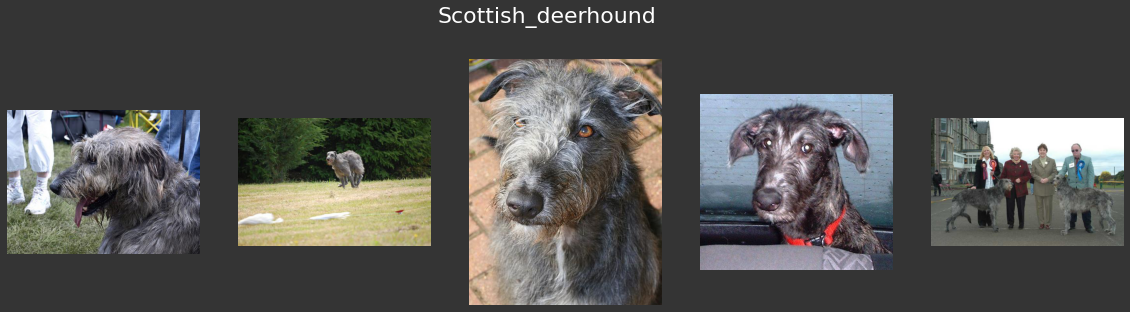

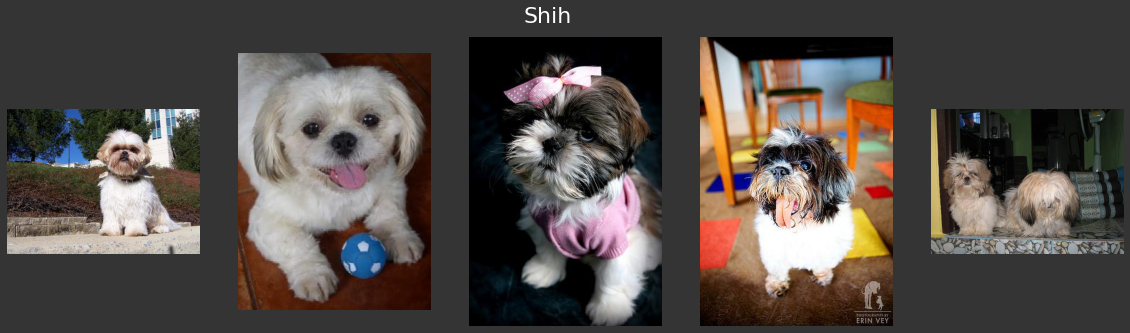

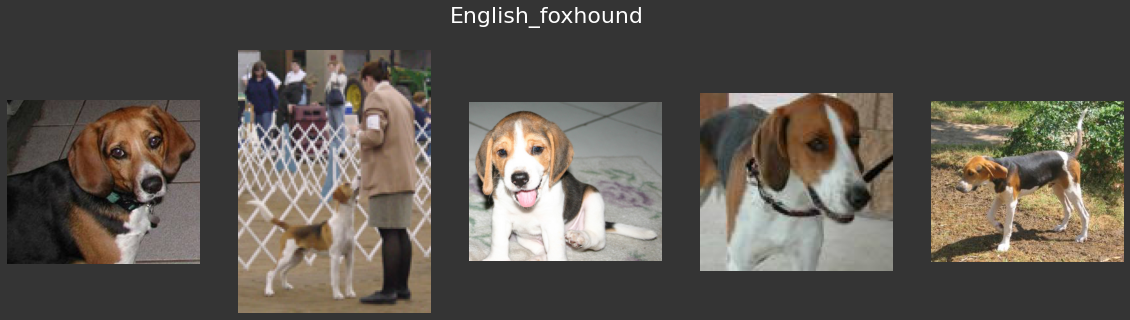

In [4]:
#From XceptRef
def show_images_classes(path, classes, num_sample):
    """This function is used to display the first 
    n images of a directory passed as an argument. 
    It is adapted to subdirectories. 
    
    The matplotlib.image library must be loaded 
    with the alias mpimg. 

    Parameters
    ----------------------------------------
    path : string
        Link of root directory
    classes : string 
        Name of the subdirectory
    num_smaple : integer
        Number of picture to show
    ----------------------------------------
    """
    fig = plt.figure(figsize=(20,20))
    fig.patch.set_facecolor('#343434')
    plt.suptitle("{}".format(classes.split("-")[1]), y=.83,
                 color="white", fontsize=22)
    images = os.listdir(path + "/" + classes)[:num_sample]
    for i in range(num_sample):
        img = mpimg.imread(path+"/"+classes+"/"+images[i])
        plt.subplot(num_sample/5+1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()
    
for i in np.random.randint(0, len(breed_list), size=3):
    show_images_classes(images_dir, breed_list[i], 5)

In [38]:
#From XceptRef
from keras.preprocessing import image

def preprocessing_cnn(directories, img_width, img_height):
    """Preprocessing of images in order to integrate them 
    into a convolutional neural network. Equalization, 
    Denoising and transformation of the image into Array. 
    Simultaneous creation of labels (y). 

    Parameters
    ---------------------------------------------------
    directoriesList : list
        List of files to be processed.
    img_width : integer
        width of the image to be reached for resizing
    img_height : integer
        height of the image to be reached for resizing
    ---------------------------------------------------
    """
    img_list=[]
    labels=[]
    for index, breed in enumerate(directories):
        for image_name in os.listdir(images_dir+"/"+breed):
            # Read image
            img = cv2.imread(images_dir+"/"+breed+"/"+image_name)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            # Resize image
            dim = (img_width, img_height)
            img = cv2.resize(img, dim, interpolation=cv2.INTER_LINEAR)
            # Equalization
            img_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
            img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
            img_equ = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
            # Apply non-local means filter on test img
            dst_img = cv2.fastNlMeansDenoisingColored(
                src=img_equ,
                dst=None,
                h=10,
                hColor=10,
                templateWindowSize=7,
                searchWindowSize=21)
            
            # Convert modified img to array
            img_array = image.img_to_array(dst_img)
            
            # Append lists of labels and images
            img_list.append(np.array(img_array))
            labels.append(breed.split("-")[1])
    
    return img_list, labels

# Define numbers of breeds to preprocess
num_breeds = len(categories) 

# Execute preprocessor on selection
# X = images
# y = labels
X, y = preprocessing_cnn(categories, 244, 244)
# Convert in numpy array
X = np.array(X)
y = np.array(y)
print("-" * 50)
print("Execution time for preprocessing :")
print("-" * 50)
print("Number of images preprocessed : {}"\
     .format(len(y)))
print("Shape of images np.array : {}"\
     .format(X.shape))

--------------------------------------------------
Execution time for preprocessing :
--------------------------------------------------
Number of images preprocessed : 2522
Shape of images np.array : (2522, 244, 244, 3)


In [183]:
saved_x = X
X = tf.keras.applications.densenet.preprocess_input(X)

model = tf.keras.applications.DenseNet201(include_top=False,weights = 'imagenet',input_shape=(244,244, 3))


#Layers added to solve some errors based on https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow
m = model.output
m= GlobalAveragePooling2D()(m)
m= BatchNormalization()(m)
m= Dropout(0.5)(m)
m= Dense(1024,activation='relu')(m) 
m= Dense(512,activation='relu')(m) 
m= BatchNormalization()(m)
m= Dropout(0.5)(m)

preds=Dense(15,activation='softmax')(m) #FC-layer
model=Model(inputs=model.input,outputs=preds)

In [184]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics= ['accuracy'])

In [143]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=48)
print("-" * 50)
print("Size of created sets :")
print("-" * 50)
print("Train set size = ",x_train.shape[0])
print("Test set size = ",x_test.shape[0])

--------------------------------------------------
Size of created sets :
--------------------------------------------------
Train set size =  2017
Test set size =  505


In [164]:
#From XceptRef
# Data generator on train set with Data Augmentation and preprocess
# Validation set is define here
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.densenet.preprocess_input)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input)

In [167]:
#Convert string labels of breeds to integers for use with sparse_categorical_crossentropy
y_train = np.array(pd.factorize(y_train)[0].tolist())
y_test = np.array(pd.factorize(y_test)[0].tolist())

In [ ]:
model.summary()

In [186]:
history=model.fit(train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
        validation_data=train_datagen.flow(
            x_train, y_train,
            batch_size=16,
            subset='validation'),
        steps_per_epoch=len(x_train) / 32,
        epochs=15, shuffle=True, verbose=2)

Epoch 1/15
64/63 - 523s - loss: 3.7399 - accuracy: 0.1152 - val_loss: 2.8250 - val_accuracy: 0.0596
Epoch 2/15
64/63 - 592s - loss: 3.0606 - accuracy: 0.2055 - val_loss: 2.7946 - val_accuracy: 0.0496
Epoch 3/15
64/63 - 611s - loss: 2.5703 - accuracy: 0.3033 - val_loss: 2.8815 - val_accuracy: 0.0670
Epoch 4/15
64/63 - 632s - loss: 2.1892 - accuracy: 0.3809 - val_loss: 3.4515 - val_accuracy: 0.0918
Epoch 5/15
64/63 - 613s - loss: 1.8789 - accuracy: 0.4628 - val_loss: 58.6552 - val_accuracy: 0.0670
Epoch 6/15
64/63 - 591s - loss: 1.6989 - accuracy: 0.5000 - val_loss: 30.6074 - val_accuracy: 0.0769
Epoch 7/15
64/63 - 620s - loss: 1.3919 - accuracy: 0.5645 - val_loss: 35.1646 - val_accuracy: 0.0670
Epoch 8/15
64/63 - 631s - loss: 1.2795 - accuracy: 0.6184 - val_loss: 63.0049 - val_accuracy: 0.0546
Epoch 9/15
64/63 - 618s - loss: 1.1889 - accuracy: 0.6494 - val_loss: 3.7190 - val_accuracy: 0.0720
Epoch 10/15
64/63 - 641s - loss: 1.1416 - accuracy: 0.6546 - val_loss: 9.3600 - val_accuracy: 0.

In [187]:
model.save('DenseNet')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: DenseNet\assets


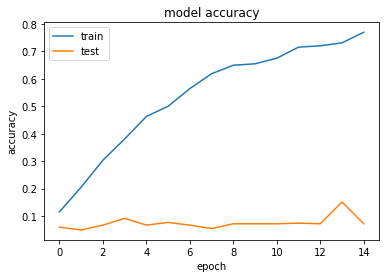

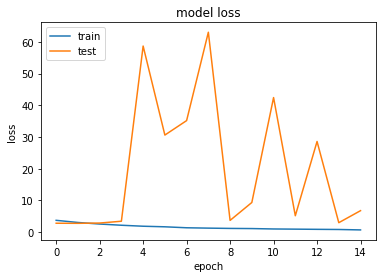

In [188]:
# plot model performance
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

plt.figure()
plt.gcf().clear()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

The model achieved 77% accuracy on the training data, however it did not perform well on the testing set. This tells us it is overfitting the training set and we need to do something to fix this.

Generating plots...


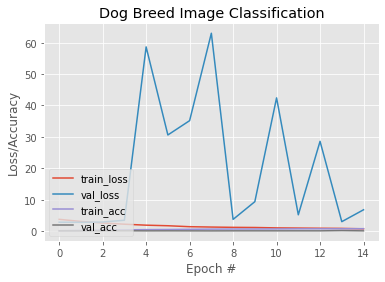

In [190]:
import sys
print("Generating plots...")
sys.stdout.flush()
matplotlib.use("Agg")
matplotlib.pyplot.style.use("ggplot")
matplotlib.pyplot.figure()
N = 15
matplotlib.pyplot.plot(np.arange(0, N), history.history["loss"], label="train_loss")
matplotlib.pyplot.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
matplotlib.pyplot.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
matplotlib.pyplot.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
matplotlib.pyplot.title("Dog Breed Image Classification")
matplotlib.pyplot.xlabel("Epoch #")
matplotlib.pyplot.ylabel("Loss/Accuracy")
matplotlib.pyplot.legend(loc="lower left")
matplotlib.pyplot.savefig("plot.png")

In [ ]:
#avoid overfitting by freezing 
#see: https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow

for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics= ['accuracy'])
model.summary()
history=model.fit(train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
        validation_data=train_datagen.flow(
            x_train, y_train,
            batch_size=16,
            subset='validation'),
        steps_per_epoch=len(x_train) / 32,
        epochs=15, shuffle=True)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_20 (ZeroPadding2 (None, 250, 250, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 122, 122, 64) 9408        zero_padding2d_20[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 122, 122, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________